<a href="https://colab.research.google.com/github/xhiroga/til/blob/main/software-engineering/deepseek-ai/Janus/_src/sandbox/Janus_Pro_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/deepseek-ai/Janus

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 121 (delta 51), reused 36 (delta 36), pack-reused 47 (from 2)
Receiving objects: 100% (121/121), 7.19 MiB | 30.93 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
%cd Janus
!pip install -e .
!pip install flash-attn

/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import sys
sys.path.append('Janus')

In [6]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def vqa(question: str, image_path: str):
    conversation = [
        {
            "role": "User",
            "content": f"<image_placeholder>\n{question}",
            "images": [image_path],
        },
        {"role": "Assistant", "content": ""},
    ]

    # load images and prepare for inputs
    pil_images = load_pil_images(conversation)
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(vl_gpt.device)

    # run image encoder to get the image embeddings
    inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

    # run the model to get the response
    outputs = vl_gpt.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=prepare_inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
        use_cache=True,
    )

    answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
    print(f"{prepare_inputs['sft_format'][0]}", answer)


Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: add_special_token, ignore_id, num_image_tokens, mask_prompt, sft_format, image_tag. 


--2025-02-09 12:56:40--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Sunflower_from_Silesia2.jpg/800px-Sunflower_from_Silesia2.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77851 (76K) [image/jpeg]
Saving to: ‘images/sample.jpg’

images/sample.jpg   100%[===================>]  76.03K  --.-KB/s    in 0.03s   

2025-02-09 12:56:40 (2.96 MB/s) - ‘images/sample.jpg’ saved [77851/77851]



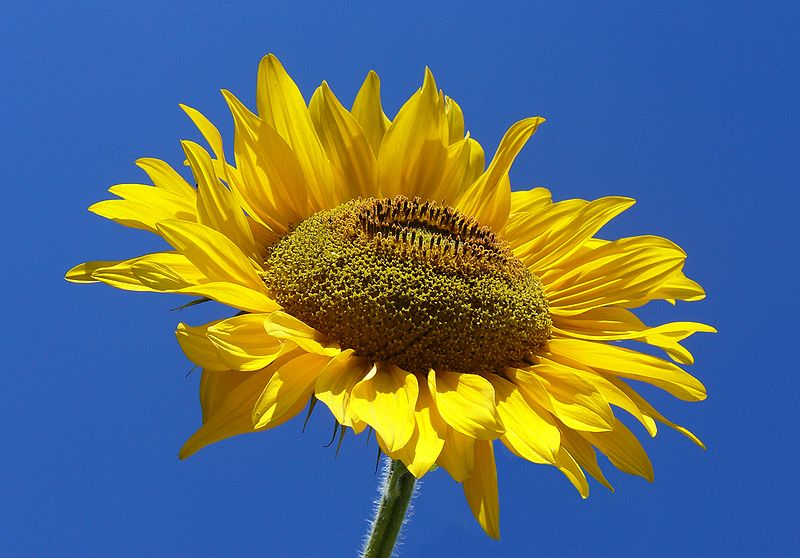

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>
What is in this picture?

Assistant: This picture features a vibrant yellow sunflower against a clear blue sky.


In [7]:
import os
from PIL import Image
from IPython.display import display


os.makedirs("images", exist_ok = True)

# Download a sample image (replace with your desired image URL)
!wget -O images/sample.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Sunflower_from_Silesia2.jpg/800px-Sunflower_from_Silesia2.jpg

# Display the downloaded image
try:
    img = Image.open("images/sample.jpg")
    display(img)
except FileNotFoundError:
    print("Error: Image file not found.")
except Exception as e:
    print(f"An error occurred: {e}")

vqa("What is in this picture?", "images/sample.jpg")
